In [1]:
using Knet, CUDA, Images, Random, Statistics,Base,NPZ,Plots
const F = Float32
Atype = CUDA.functional() ? KnetArray{F} : Array{F};

include("model.jl")
include("utils.jl")
using .model
using .utils

In [2]:
data_mean,data_std = 27.297162446216674, 47.47356353999097

(27.297162446216674, 47.47356353999097)

In [3]:
train_data = npzread("../../Datasets/DenoiseSeg_Mouse_s&p_new.npz");
xtst=train_data["test_GT"];
test_noisy = train_data["test"]
xtst=permutedims(xtst, [2, 3, 1]);
test_noisy=permutedims(test_noisy, [2, 3, 1]);

In [4]:
dtst = minibatch(test_noisy,xtst, 1; xsize = (256, 256, 1,:),ysize = (256, 256, 1,:), xtype = Atype,ytype=Atype);

In [5]:
function inference_forward(w,x,y_hat,data_mean,data_std,n)
    wdec, wenc = w[:decoder], w[:encoder]
    x_normalized = (x .- data_mean)./ data_std
    mu, logvar = encode(wenc, x_normalized)
    y_total = Atype(zeros(Float32,size(x)))
    for i in 1:n
        z = reparameterize(mu,logvar)
        y = decode(wdec,z)
        y  = (y.*data_std) .+ data_mean
        y_total = y_total .+ y
    end
    y_total = y_total./n
    return MSE(y_hat,y_total)
end

inference_forward (generic function with 1 method)

# Fully Unsupervised

In [6]:
w = Knet.load("mouse_s&p_fully_unsupervised.jld2","w",);

In [7]:
psnr_list_10 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,10)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_10,psnr)
end

In [8]:
psnr_list_100 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,100)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_100,psnr)
end

In [9]:
psnr_list_1000 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,1000)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_1000,psnr)
end

In [10]:
println("mean PSNR and std over 5 runs\n")
println("Paper Reported Result")
println("1000 samples MMSE estimate : mean : 35.19 std :0.030")
println("-------------------\n")
println("10 samples MMSE estimate : mean : "*string(mean(psnr_list_10))*" std "*string(std(psnr_list_10)))
println("100 samples MMSE estimate : mean : "*string(mean(psnr_list_100))*" std "*string(std(psnr_list_100)))
println("1000 samples MMSE estimate : mean : "*string(mean(psnr_list_1000))*" std "*string(std(psnr_list_1000)))

mean PSNR and std over 5 runs

Paper Reported Result
1000 samples MMSE estimate : mean : 35.19 std :0.030
-------------------

10 samples MMSE estimate : mean : 35.925285 std 0.0037688373
100 samples MMSE estimate : mean : 36.177055 std 0.0014298552
1000 samples MMSE estimate : mean : 36.202908 std 0.0006146074


# Run once training is finished

In [15]:
trn_recon_loss = Knet.load("recon_kld_loss/trn_recon_loss_fully_unsupervised.jld2","trn_recon_loss",)
trn_KLD_loss = Knet.load("recon_kld_loss/trn_KLD_loss_fully_unsupervised.jld2","trn_KLD_loss",)
val_recon_loss = Knet.load("recon_kld_loss/val_recon_loss_fully_unsupervised.jld2","val_recon_loss",)
val_KLD_loss = Knet.load("recon_kld_loss/val_KLD_loss_fully_unsupervised.jld2","val_KLD_loss",);

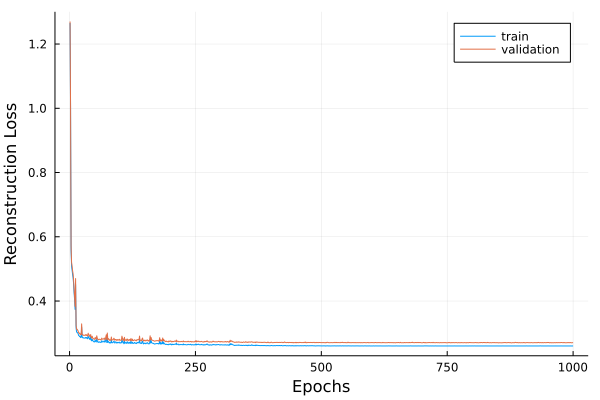

In [16]:
plot([trn_recon_loss, val_recon_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Reconstruction Loss")

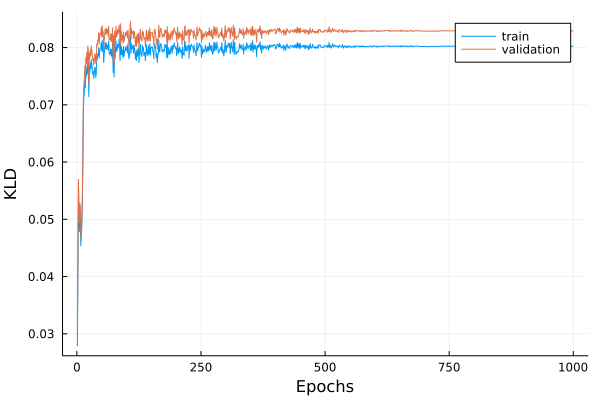

In [17]:
plot([trn_KLD_loss, val_KLD_loss],#ylim=(0.0,0.5),
     labels=["train" "validation"],xlabel="Epochs",ylabel="KLD")

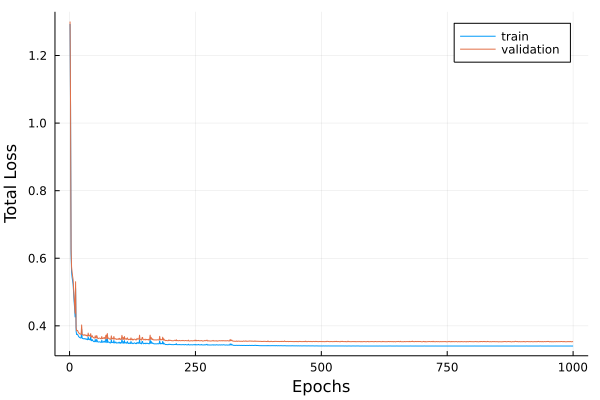

In [18]:
plot([trn_recon_loss.+trn_KLD_loss, val_recon_loss.+val_KLD_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Total Loss")